In [21]:
import torch

In [22]:
### Select device (GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print('Selected device:', device)

Selected device: cuda


In [23]:
with open('../data-sets/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

dataset = text

import random
print('Random line:', random.choice(dataset.split('\n')))
print('Size of dataset:', len(dataset.split('\n')), 'lines')

Random line: yesterday; for the other has half, by the entreaty
Size of dataset: 40001 lines


In [24]:
unique_chars = sorted(set(dataset))

print(unique_chars)

char_to_num = {char: num for num, char in enumerate(unique_chars)}
num_to_char = {num: char for char, num in char_to_num.items()}

Vs = len(unique_chars) # Vocabulary size |V|
print('Number of unique chars:', Vs)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Number of unique chars: 65


In [25]:
### Create data set ###
n = 15

def build_dataset(data):
    X, Y = [], []
    
    context = [0] * n
    
    for ch in data:
        X.append(context)
        ix = char_to_num[ch]
        Y.append(ix)
        context = context[1:] + [ix]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)

    return X, Y

split = int(0.8 * len(dataset))

Xtr, Ytr = build_dataset(dataset[:split])
Xte, Yte = build_dataset(dataset[split:])

import random
ix = random.randint(0, len(Xtr) - 1) 
print('Random example:', Xtr[ix].tolist(), '=>', Ytr[ix].item())
print('Amount of train examples:', len(Xtr))

Random example: [57, 1, 41, 59, 56, 57, 43, 42, 1, 46, 39, 52, 42, 0, 25] => 59
Amount of train examples: 892315


In [26]:
import torch.nn as nn

### Initialize Neural Network ###

m = 20  # The number of features associated with each char
h = 250 # The number of hidden units

model = nn.Sequential(
    nn.Embedding(Vs, m),
    nn.Flatten(),
    nn.Linear(n * m, h, bias=False), nn.LayerNorm(h), nn.Tanh(),
    nn.Linear(h,     h, bias=False), nn.LayerNorm(h), nn.Tanh(),
    nn.Linear(h,     h, bias=False), nn.LayerNorm(h), nn.Tanh(),
    nn.Linear(h,     Vs)
).to(device)

with torch.no_grad():
    model[-1].weight *= 0.1

# for p in model.parameters():
#     p.requires_grad = True

print('Total parameters:', sum(p.numel() for p in model.parameters()))

Total parameters: 219115


In [27]:
import torch.nn.functional as F

### Train model ###
epochs = 100000
batch_size = 128
lr = 0.1
eval_batch_size = 10000

epoch_count = []
loss_values = []

from tqdm import trange
for epoch in trange(epochs):
    model.train()
    
    # Sample mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # Logits shape = B x vocab_size, Yb shape = B

    # Zero grad params
    for p in model.parameters():
        p.grad = None

    # Backpropagation
    loss.backward()

    # Step
    for p in model.parameters():
        p.data += -lr * p.grad

    # Report progression every so often
    if ((epoch + 1) % (epochs / 200) == 0):
        
        ix = torch.randint(0, Xtr.shape[0], (eval_batch_size,), device=device)
        Xb, Yb = Xtr[ix], Ytr[ix]
    
        model.eval()
        with torch.inference_mode():
            logits = model(Xb)
            loss = F.cross_entropy(logits, Yb)

        epoch_count.append(epoch)
        loss_values.append(loss.detach().item())

# Evaluate model on test data after training is finished
ix = torch.randint(0, Xte.shape[0], (eval_batch_size,), device=device)
Xb, Yb = Xte[ix], Yte[ix]

model.eval()
with torch.inference_mode():
  logits = model(Xb)
  test_loss = F.cross_entropy(logits, Yb)

# Print final results
print('Final training loss:', round(loss.item(), 3))
print('Final test loss:', round(test_loss.item(), 3))

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [01:10<00:00, 1410.07it/s]

Final training loss: 1.339
Final test loss: 1.733


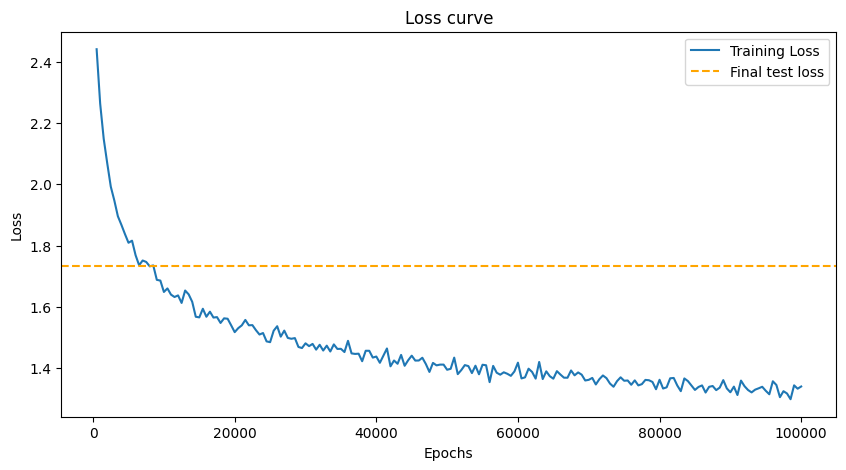

In [28]:
import matplotlib.pyplot as plt

### Visualize loss progression ###
plt.figure(figsize=(10, 5))
plt.plot(epoch_count, loss_values, label="Training Loss")
plt.axhline(y = test_loss.item(), linestyle='dashed', color='orange', label="Final test loss")
plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [29]:
### Use model ###

model.eval()

out = []
context = [0] * n

while len(out) < 1000:
    with torch.inference_mode():
        logits = model(torch.tensor([context], device=device))
    probs = F.softmax(logits.detach(), dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(num_to_char[ix])

print(''.join(out))

LIMARES:
What in any haile before as good day hand;
If no his brace paint,
To it is to the soldiers.
What no good for corn
Frank, 'tis down or a cloud he slain
By nerts bass:
Now us down, I drance, farewell of thy guardness is many gracious ennow
Thou better?

EDWARD:
I thank it is a bawd!

JULIET:
I'll bear you, rid, with your heir.

PAULINA:
Pray aside, friend.

MENENIUS:
Ouiriss,
Which house.'
Had it grosperate.

RICHMOND:
What hate, by Margiring some breath Romeo
He marrike and foe, how I have madmets son, v's father Clarence, go, let itself wear wight of bidst and by Richmond,
A kind obshour with him: and homs.

CORIOLANUS:
Pray, lad, I mainted
Some fortune.
Seajsa'd the dam;
You arken cames, to make these suit busy might with ourse
To have bereffer fronk.

SuMPRLE:
Meld shepherd's truck you quickly know!

MERCUTIO:
What is thy loss in death:
Ay woe a flather
shepherd Camillo?

MENENIUS:
Be shall his supposed by my son him! O crackly hand from my weak his slain-back our backs?

PO